**Imports and Reading Data**

# **Reading Dataset**

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
!pip install tensorflow keras

In [ ]:

import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: haidyabou
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 158MB/s]


In [ ]:
!pip install tqdm
!pip install opencv-python


# **Preprocess The Dataset**




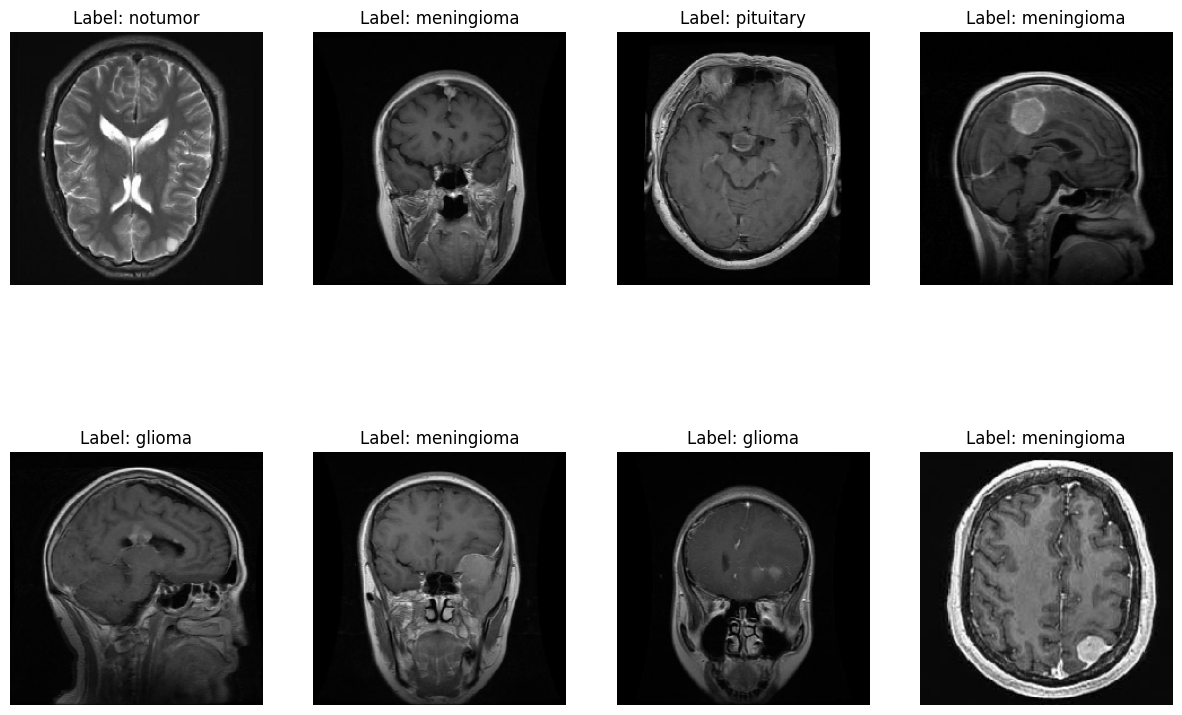

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess the image
def load_and_preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

dataset_path = "/content/brain-tumor-mri-dataset/Training"

#  list of all image paths in the dataset
all_image_paths = []
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)  # Correctly join dataset_path with class_folder
    image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    all_image_paths.extend(image_paths)

#  random subset of images
random_images = random.sample(all_image_paths, k=min(8, len(all_image_paths)))  # Adjust the number as needed

# the target size for visualization (e.g., 224x224)
target_size_visualization = (224, 224)

# Plot the images in a grid
plt.figure(figsize=(15, 10))
for i, image_path in enumerate(random_images, 1):
    plt.subplot(2, 4, i)  # 2 rows, 4 columns grid

    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path, target_size_visualization)

    # Display the image
    plt.imshow(img_array)

    # Display the label (extracted from the folder name)
    label = image_path.split("/")[-2]  # Assumes the label is the second-to-last part of the path
    plt.title(f"Label: {label}")

    plt.axis("off")

plt.show()


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = "/content/brain-tumor-mri-dataset/Training"
test_path = "/content/brain-tumor-mri-dataset/Testing"

target_size = (224, 224)  # VGG16 was trained on 224x224 images

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Preprocess images for VGG16
    shear_range=0.2,  # Apply shear transformation with a range of 0.2
    zoom_range=0.2,  # Apply zoom transformation with a range of 0.2
    horizontal_flip=True  # Flip images horizontally
)

# Preprocessing for testing data (no data augmentation to make the size close to original images )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Flow images from the directories using the generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'  # Use categorical labels for multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **Transfer Learning**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers in the base model by default
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

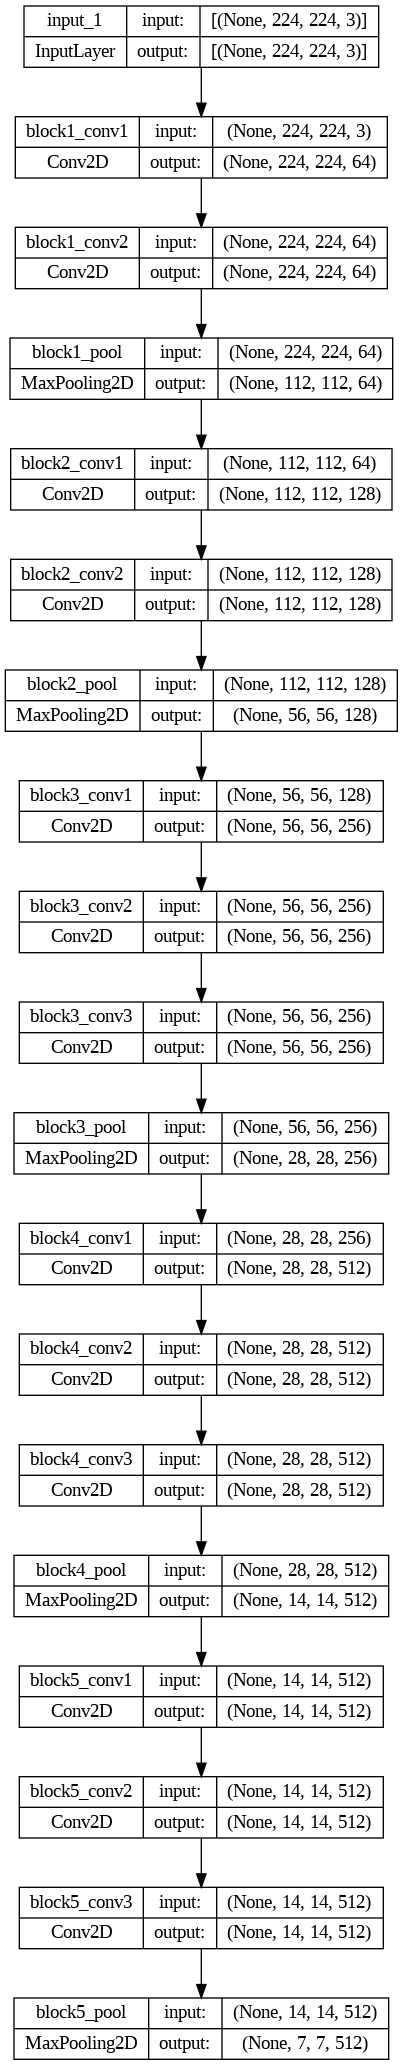

In [ ]:
from tensorflow.keras.utils import plot_model

# Save a visual representation of the model architecture to a file
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
import numpy as np

param_grid = {'epochs': [20,30 ,40,60,80]}
num_classes = 4
results = []

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model by default
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model for 20 epochs
history_20 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Evaluate the model
score_20 = model.evaluate(test_generator, verbose=0)

# Append the results
results.append(({'epochs': 20}, score_20[1]))  # Assuming score_20[1] is accurac

Epoch 1/20
178/178 [==============================] - 116s 593ms/step - loss: 3.6881 - accuracy: 0.7544 - val_loss: 0.4049 - val_accuracy: 0.8633
Epoch 2/20
178/178 [==============================] - 85s 478ms/step - loss: 0.5304 - accuracy: 0.8099 - val_loss: 0.3673 - val_accuracy: 0.8562
Epoch 3/20
178/178 [==============================] - 89s 502ms/step - loss: 0.4959 - accuracy: 0.8220 - val_loss: 0.3340 - val_accuracy: 0.8813
Epoch 4/20
178/178 [==============================] - 86s 479ms/step - loss: 0.4451 - accuracy: 0.8368 - val_loss: 0.3661 - val_accuracy: 0.8680
Epoch 5/20
178/178 [==============================] - 88s 493ms/step - loss: 0.4083 - accuracy: 0.8452 - val_loss: 0.2974 - val_accuracy: 0.8852
Epoch 6/20
178/178 [==============================] - 89s 502ms/step - loss: 0.3960 - accuracy: 0.8528 - val_loss: 0.3062 - val_accuracy: 0.8828
Epoch 7/20
178/178 [==============================] - 88s 493ms/step - loss: 0.3399 - accuracy: 0.8683 - val_loss: 0.2846 - val_a

In [ ]:
results

[({'epochs': 20}, 0.9580472707748413)]

In [ ]:

model.save('vgg16_custom_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json

# Save the test results to a file
results_to_save = [{'epochs': 20, 'accuracy': score_20[1]}]
with open('test_results.json', 'w') as file:
    json.dump(results_to_save, file)


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Path to your trained model
model_path = "/content/vgg16_custom_model.h5"

# Load the trained model
loaded_model = load_model(model_path)

# Load an image for prediction
img_path = "/content/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0095.jpg"
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make a prediction
predictions = loaded_model.predict(img)

# Assuming you have a list of class labels
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]  # Replace with your actual class labels

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")

# Display the image with the predicted class
plt.imshow(img[0].astype(np.uint8))  # Show the image
plt.title(f"Predicted class: {predicted_class_label}")  # Set the title
plt.axis('off')  # Turn off axis labels
plt.show()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Load the base VGG16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model by default
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model with the updated argument
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history_30 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model
score_30 = model.evaluate(test_generator, verbose=0)

# Append the results
results.append(({'epochs': len(history_30.epoch)}, score_30[1]))  # Assuming score_30[1] is accuracy


Epoch 1/30
178/178 [==============================] - 131s 728ms/step - loss: 3.5637 - accuracy: 0.7188 - val_loss: 0.4154 - val_accuracy: 0.8547
Epoch 2/30
178/178 [==============================] - 131s 733ms/step - loss: 0.5674 - accuracy: 0.7942 - val_loss: 0.3623 - val_accuracy: 0.8734
Epoch 3/30
178/178 [==============================] - 129s 721ms/step - loss: 0.5325 - accuracy: 0.7995 - val_loss: 0.3430 - val_accuracy: 0.8680
Epoch 4/30
178/178 [==============================] - 129s 725ms/step - loss: 0.4594 - accuracy: 0.8283 - val_loss: 0.4353 - val_accuracy: 0.8750
Epoch 5/30
178/178 [==============================] - 129s 722ms/step - loss: 0.4254 - accuracy: 0.8500 - val_loss: 0.3537 - val_accuracy: 0.8680
Epoch 6/30
178/178 [==============================] - 130s 730ms/step - loss: 0.4247 - accuracy: 0.8489 - val_loss: 0.2767 - val_accuracy: 0.9117
Epoch 7/30
178/178 [==============================] - 129s 725ms/step - loss: 0.3807 - accuracy: 0.8600 - val_loss: 0.2984 -

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Load the base VGG16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model by default
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model with the updated argument
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history_40 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model
score_40 = model.evaluate(test_generator, verbose=0)

# Append the results
results.append(({'epochs': len(history_40.epoch)}, score_40[1]))  # Assuming score_30[1] is accuracy


Epoch 1/40
178/178 [==============================] - 137s 767ms/step - loss: 3.1787 - accuracy: 0.7502 - val_loss: 0.4479 - val_accuracy: 0.8508
Epoch 2/40
178/178 [==============================] - 137s 765ms/step - loss: 0.5876 - accuracy: 0.7982 - val_loss: 0.3898 - val_accuracy: 0.8453
Epoch 3/40
178/178 [==============================] - 137s 768ms/step - loss: 0.4730 - accuracy: 0.8349 - val_loss: 0.2943 - val_accuracy: 0.8938
Epoch 4/40
178/178 [==============================] - 137s 768ms/step - loss: 0.4323 - accuracy: 0.8516 - val_loss: 0.2916 - val_accuracy: 0.8953
Epoch 5/40
178/178 [==============================] - 136s 765ms/step - loss: 0.4073 - accuracy: 0.8488 - val_loss: 0.2922 - val_accuracy: 0.8891
Epoch 6/40
178/178 [==============================] - 137s 766ms/step - loss: 0.3510 - accuracy: 0.8665 - val_loss: 0.2334 - val_accuracy: 0.9203
Epoch 7/40
178/178 [==============================] - 138s 774ms/step - loss: 0.3690 - accuracy: 0.8657 - val_loss: 0.2592 -

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Load the base VGG16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model by default
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model with the updated argument
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

# Train the model with early stopping and learning rate reduction
history_60 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=60,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
score_60 = model.evaluate(test_generator, verbose=0)

# Append the results
results.append(({'epochs': len(history_60.epoch)}, score_60[1]))  # Assuming score_60[1] is accuracy


Epoch 1/60
178/178 [==============================] - 94s 523ms/step - loss: 6.2647 - accuracy: 0.7558 - val_loss: 2.6815 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 2/60
178/178 [==============================] - 94s 531ms/step - loss: 2.3888 - accuracy: 0.8042 - val_loss: 1.8929 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 3/60
178/178 [==============================] - 91s 512ms/step - loss: 1.8418 - accuracy: 0.8239 - val_loss: 1.5145 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 4/60
178/178 [==============================] - 89s 499ms/step - loss: 1.5817 - accuracy: 0.8261 - val_loss: 1.4251 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 5/60
178/178 [==============================] - 89s 497ms/step - loss: 1.3942 - accuracy: 0.8261 - val_loss: 1.2168 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 6/60
178/178 [==============================] - 87s 489ms/step - loss: 1.2342 - accuracy: 0.8254 - val_loss: 1.0694 - val_accuracy: 0.8695 - lr: 0.0010
Epoch 7/60
178/178 [==============================] 

In [ ]:
results

[({'epochs': 20}, 0.9488939642906189), ({'epochs': 60}, 0.9763539433479309)]

In [ ]:
from keras.models import load_model
model.save("/content/BrainTumorMRI.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 19ms/step
Predicted class: meningioma


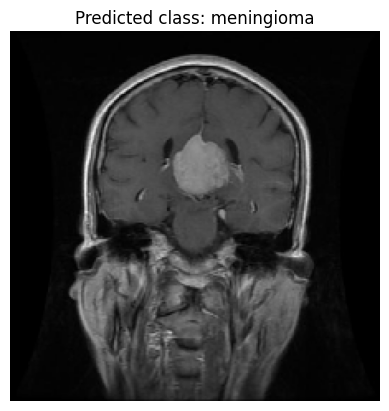

In [ ]:

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load an image for prediction
img = image.load_img("/content/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0095.jpg", target_size=(224, 224))  # Adjust target_size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make a prediction
predictions = loaded_model.predict(img)

# Assuming you have a list of class labels
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]  # Replace with your actual class labels

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")

plt.imshow(img[0].astype(np.uint8))  # Show the image
plt.title(f"Predicted class: {predicted_class_label}")  # Set the title
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

# Map class indices to class labels
class_labels = {i: class_name for i, class_name in enumerate(class_names)}


41/41 [==============================] - 6s 148ms/step


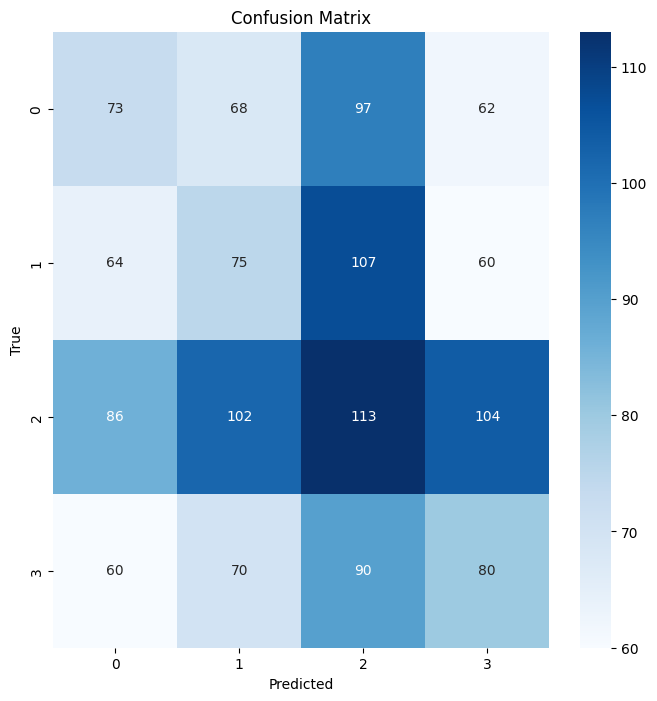

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
y_pred = model.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels
y_true = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("/content/BrainTumorMRI.h5")

In [ ]:
# Evaluate the model on the test set
eval_result = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Test Accuracy:", eval_result[1])


40/40 [==============================] - 6s 139ms/step - loss: 0.1684 - accuracy: 0.9773
Test Accuracy: 0.977343738079071


1/1 [==============================] - 1s 1s/step
Predicted class: meningioma


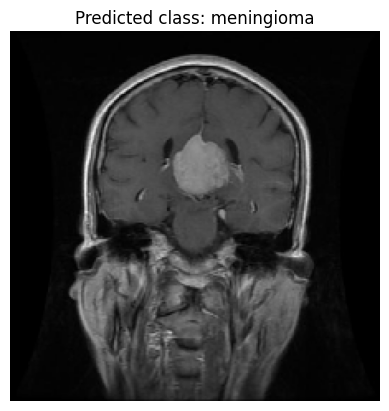

In [ ]:

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load an image for prediction
img = image.load_img("/content/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0095.jpg", target_size=(224, 224))  # Adjust target_size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make a prediction
predictions = loaded_model.predict(img)

# Assuming you have a list of class labels
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]  # Replace with your actual class labels

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")

plt.imshow(img[0].astype(np.uint8))  # Show the image
plt.title(f"Predicted class: {predicted_class_label}")  # Set the title
plt.axis('off')  # Turn off axis labels
plt.show()

1/1 [==============================] - 0s 34ms/step
Predicted class: glioma


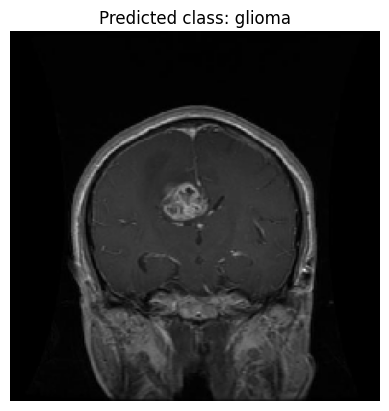

In [ ]:

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load an image for prediction
img = image.load_img("/content/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0095.jpg", target_size=(224, 224))  # Adjust target_size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make a prediction
predictions = loaded_model.predict(img)

# Assuming you have a list of class labels
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]  # Replace with your actual class labels

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")

plt.imshow(img[0].astype(np.uint8))  # Show the image
plt.title(f"Predicted class: {predicted_class_label}")  # Set the title
plt.axis('off')  # Turn off axis labels
plt.show()

1/1 [==============================] - 0s 26ms/step
Predicted class: notumor


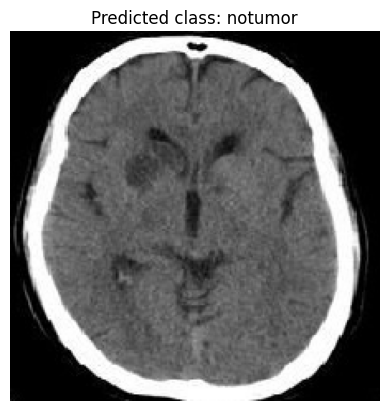

In [ ]:

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load an image for prediction
img = image.load_img("/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0080.jpg", target_size=(224, 224))  # Adjust target_size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make a prediction
predictions = loaded_model.predict(img)

# Assuming you have a list of class labels
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]  # Replace with your actual class labels

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")

plt.imshow(img[0].astype(np.uint8))  # Show the image
plt.title(f"Predicted class: {predicted_class_label}")  # Set the title
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image

def predict(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_names = ['class1', 'class2', 'class3', 'class4']  # Replace with your class names
    return class_names[class_idx]

# Create the Gradio Interface
interface = gr.Interface(fn=predict, inputs="image", outputs="label")

# Launch the Interface
interface.launch()






## Fine-Tunning

**Unfreeze the Top Layers**

In [ ]:
for layer in base_model.layers:
    layer.trainable = True


**Recompile the Model:**
Compile the model with a lower learning rate to prevent the model from making large updates to the weights during training

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load the base VGG16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model by default
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

# Train the model with early stopping and learning rate reduction
history_60 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=60,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
score_60 = model.evaluate(test_generator, verbose=0)

# Append the results
results.append(({'epochs': len(history_60.epoch)}, score_60[1]))  # Assuming score_60[1] is accuracy

# Fine-tuning: Unfreeze some layers in the base model
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,  # Fine-tune for additional epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the fine-tuned model
score_fine_tune = model.evaluate(test_generator, verbose=0)

# Append the fine-tuning results
results.append(({'epochs': len(history_fine_tune.epoch)}, score_fine_tune[1]))  # Assuming score_fine_tune[1] is accuracy

print("Initial training accuracy:", score_60[1])
print("Fine-tuning accuracy:", score_fine_tune[1])


Epoch 1/60
178/178 [==============================] - 107s 539ms/step - loss: 6.3481 - accuracy: 0.7484 - val_loss: 2.5944 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 2/60
178/178 [==============================] - 83s 466ms/step - loss: 2.3275 - accuracy: 0.8005 - val_loss: 1.9520 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 3/60
178/178 [==============================] - 82s 462ms/step - loss: 1.8578 - accuracy: 0.7970 - val_loss: 1.5506 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 4/60
178/178 [==============================] - 82s 460ms/step - loss: 1.5054 - accuracy: 0.8206 - val_loss: 1.3112 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 5/60
178/178 [==============================] - 81s 455ms/step - loss: 1.3490 - accuracy: 0.8120 - val_loss: 1.1241 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 6/60
178/178 [==============================] - 86s 483ms/step - loss: 1.1842 - accuracy: 0.8224 - val_loss: 0.9868 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 7/60
178/178 [==============================]

In [ ]:
model.save("/content/BrainTumorMRI.h5")

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config',
 'brain-tumor-mri-dataset',
 'BrainTumorMRI.h5',
 'model_plot.png',
 'sample_data']

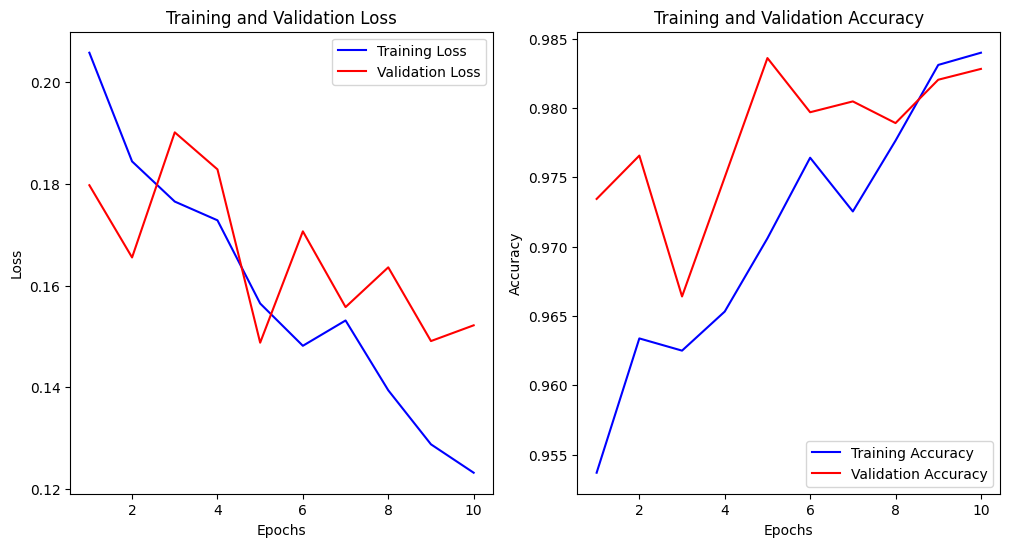

In [ ]:
import matplotlib.pyplot as plt

# Extract data from the history object
train_loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']
train_accuracy = history_fine_tune.history['accuracy']
val_accuracy = history_fine_tune.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load the base VGG16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model by default
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Additional layer
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

# Train the model with early stopping and learning rate reduction
history_60 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=60,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
score_60 = model.evaluate(test_generator, verbose=0)

# Fine-tuning: Unfreeze some layers in the base model
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,  # Fine-tune for additional epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the fine-tuned model
score_fine_tune = model.evaluate(test_generator, verbose=0)

print("Initial training accuracy:", score_60[1])
print("Fine-tuning accuracy:", score_fine_tune[1])


Epoch 1/60
178/178 [==============================] - 101s 502ms/step - loss: 8.6963 - accuracy: 0.5697 - val_loss: 4.5398 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 2/60
178/178 [==============================] - 86s 485ms/step - loss: 4.2185 - accuracy: 0.5611 - val_loss: 3.6778 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 3/60
178/178 [==============================] - 86s 480ms/step - loss: 3.4554 - accuracy: 0.5481 - val_loss: 2.8869 - val_accuracy: 0.7203 - lr: 0.0010
Epoch 4/60
178/178 [==============================] - 82s 462ms/step - loss: 2.9378 - accuracy: 0.5835 - val_loss: 2.5694 - val_accuracy: 0.6617 - lr: 0.0010
Epoch 5/60
178/178 [==============================] - 86s 484ms/step - loss: 2.5391 - accuracy: 0.6040 - val_loss: 2.2336 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 6/60
178/178 [==============================] - 82s 458ms/step - loss: 2.2867 - accuracy: 0.6136 - val_loss: 1.9985 - val_accuracy: 0.6594 - lr: 0.0010
Epoch 7/60
178/178 [==============================]

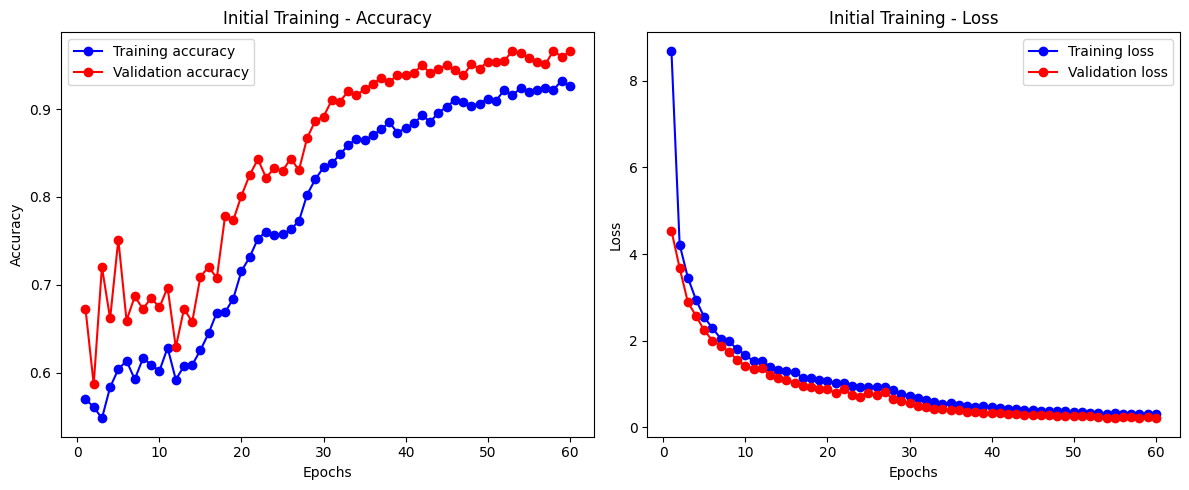

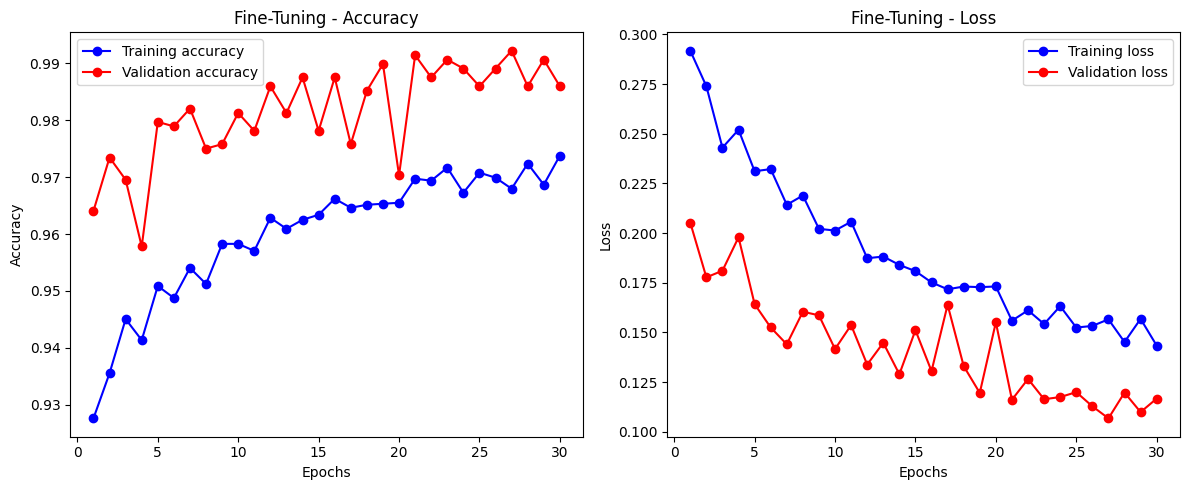

In [ ]:
import matplotlib.pyplot as plt

# Plotting function to visualize training and validation metrics
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the initial training history
plot_training_history(history_60, 'Initial Training')

# Plot the fine-tuning training history
plot_training_history(history_fine_tune, 'Fine-Tuning')


In [ ]:
# Save the entire model to a file
model.save('/content/sample_data/Lastmodel.h5')
print("Model saved successfully.")


Model saved successfully.


In [ ]:
model.save('vgg16_lastmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/Lastmodel.h5')


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.4 MB/s et

In [ ]:
from keras.models import load_model

# Load the saved model
model = load_model('/content/brain-tumor-mri-dataset/Lastmodel')


In [ ]:
import tensorflow as tf

def predict_image(inp):
    inp = inp.reshape((-1, 224, 224, 3))
    inp = tf.keras.applications.mobilenet_v2.preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    confidences = {labels[i]: float(prediction[i]) for i in range(1000)}
    return confidences


In [ ]:
from keras.models import load_model
import tensorflow as tf
import gradio as gr

# Load the saved model
model = load_model('/content/Lastmodel.h5')

# Define the labels for your classes
labels = ["meningioma", "glioma", "notumor", "pituitary"]

def predict_image(inp):
    inp = tf.image.resize(inp, (224, 224))  # Resize the image
    inp = tf.keras.applications.mobilenet_v2.preprocess_input(inp)
    inp = tf.expand_dims(inp, axis=0)  # Expand dimensions to match model input
    prediction = model.predict(inp).flatten()
    confidences = {labels[i]: float(prediction[i]) for i in range(len(labels))}
    return confidences

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(),
    title="Image Classification Demo",
    description="Upload an image to classify its content."
)

# Launch the interface
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0d846c38127b215217.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
from keras.models import load_model
import tensorflow as tf
import gradio as gr

# Load the saved model
model = load_model('/content/Lastmodel.h5')

# Print model summary for debugging
model.summary()

# Define the labels for your classes
labels = ["glioma", "meningioma", "notumor", "pituitary"]

def predict_image(inp):
    inp = tf.image.resize(inp, (224, 224))  # Resize the image
    inp = tf.keras.applications.vgg16.preprocess_input(inp)
    inp = tf.expand_dims(inp, axis=0)  # Expand dimensions to match model input

    # Get predictions
    prediction = model.predict(inp).flatten()

    # Debugging: Print the prediction values and corresponding labels
    print(f"Predictions: {prediction}")
    for i, prob in enumerate(prediction):
        print(f"Class: {labels[i]}, Probability: {prob}")

    # Get the label with the highest probability
    predicted_index = prediction.argmax()
    predicted_label = labels[predicted_index]

    # Debugging: Print the predicted index and label
    print(f"Predicted Index: {predicted_index}, Predicted Label: {predicted_label}")

    return predicted_label

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(),
    title="Image Classification Demo",
    description="Upload an image to classify its content."
)

# Launch the interface
iface.launch()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                

In [ ]:
!pip install --upgrade gradio
